# 几何生成器模型

在本教程中，我们将探索在 [`networkx/generators/geometric.py`](https://github.com/networkx/networkx/blob/main/networkx/generators/geometric.py) 下实现的几何网络生成器模型，并将其应用于一个实际案例，以了解这些模型如何被参数化和使用。

## 导入包

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## 几何/空间网络

许多现实世界的复杂系统具有空间成分，这些成分限制了这类系统所能产生的网络结构。基础设施网络，如交通、电力和通信系统，社交网络，甚至我们自己的突触网络，都嵌入在物理空间中。空间网络为具有空间元素的网络模型提供了一个框架，其中节点嵌入在空间中，并且引入了一个度量标准，该标准规定了节点之间连接的条件。通常，连接的概率是度量的递减函数，大多数模型假设二维或三维的欧几里得距离。大多数空间网络模型的直觉是，节点之间距离越远，连接成本越高，尽管可以建模任意连接概率函数。

空间网络应用于如此广泛的现实世界系统的潜力，激发了对这些网络的持续研究，提出了许多独特但密切相关的模型，其中许多模型的网络属性有理论证明。Marc Barthélemy 在 2010 年的空间网络综述文章 [^1] 提供了该领域的全面概述，并回顾了许多最常见的空间网络模型的最重要理论证明。在这里，我们探索了一些最典型的空间网络模型，这些模型已在 networkx 包中实现。这些模型可以使用这三个模型参数进行分类：

 - $R$ - 最大连接距离，networkx 中的 `radius` 参数
 - $P(d_{ij})$ - 边缘连接的概率作为节点 $i, j$ 之间距离 $d_{ij}$ 的函数，其中 $i \neq j$，networkx 中的 `p_dist` 参数
 - $\theta$ - 连接的节点权重阈值，networkx 中的 `theta` 参数

通常，节点均匀分布在单位正方形上，节点权重从某个权重分布中采样。距离 $d_{ij}$ 通常假设为欧几里得距离，但某些 networkx 模型允许自定义度量标准，而其他模型仅允许 Minkowski 距离度量。

下图显示了空间网络模型之间的关系，它们共享参数化。

![spatial_networks](images/spatial_networks.png "Spatial Networks")

### 单个模型定义

本节总结了各种模型。符号 $E_{ij}$ 表示节点 $i$ 和 $j$ 之间存在边。

#### 随机几何图 ($R$)

一个 d 维随机几何图 (RGG) 是一个图，其中每个 $N$ 节点在盒子 $[0, 1]^{d}$ 中被赋予随机坐标，并且只有彼此“接近”的节点通过边连接 [^2]。任何在最大连接距离 $R$ 内或等于 $R$ 的节点都是连接节点，网络的结构完全由 $R$ 定义。RGG，类似于单位圆盘图 [^3]，已被广泛用于模拟无线自组织网络。

$$ E_{ij}: d_{ij} \leq R $$

#### Waxman 图 ($\alpha$)

Waxman 图是 Erdős–Rényi 随机图的空间泛化，其中节点连接的概率取决于它们之间距离的函数 [^4]。Waxman 最初提出的边概率函数是 $d_{ij}$ 的指数函数，提供了两个连接概率调整参数，$\alpha$ 和 $\beta$：

$$ P(d_{ij}) = \beta e^{\frac{-d_{ij}}{L \alpha}} $$ 

其中 $L$ 是每对节点之间的最大距离。

边概率函数 $P(d_{ij})$ 的形状在确定 Waxman 图的结构中起着关键作用，但现实世界网络中 $P(d_{ij})$ 的特征仍然存在争议。最常研究的功能家族是上述原始指数函数，或幂律，$-{d_{ij}}^{-\alpha}$。

$$ E_{ij} \propto P(d_{ij}) $$

#### 阈值图 ($\theta$)

一个简单图 $G$ 是阈值图，如果我们能为顶点分配权重
使得一对不同的顶点相邻，当且仅当它们被赋予的权重之和等于或超过一个指定的阈值，$\theta$ [^6]。阈值图本身并不是空间网络，因为它们不包含特定的几何或度量，但它们引入了将节点权重作为网络模型一部分的能力，这在其他空间网络模型中得到应用，例如几何阈值图。

$$ E_{ij}: (w_i + w_j) \geq \theta $$

#### 地理阈值图 ($P(d_{ij}), \theta$)

地理阈值图是阈值图的地理概括，其中一对具有权重 $w_i, w_j$ 和距离 $d_{ij}$ 的顶点相连，当且仅当权重 $w_i$ 和 $w_j$ 之和与边连接函数 $P(d_{ij})$ 的乘积大于或等于一个阈值 $\theta$ [^8]。

$$ E_{ij}: (w_i + w_j) P(d_{ij}) \geq \theta $$

#### 软随机几何图 ($R, P(d_{ij})$)

随机几何图的一个近期扩展考虑了在最大连接距离 $R$ 内节点间距离的影响，以更好地模拟现实世界系统，其中节点接近并不一定保证“接近”节点之间的连接。在软随机几何图中，节点 $i$ 和 $j$ 之间的连接概率是其距离 $d_{ij}$ 的函数，如果 $d_{ij} \leq R$。否则，它们不连接 [^7]。

$$ E_{ij} \propto P(d_{ij}) \textrm{ if } d_{ij} \leq R $$

#### 阈值随机几何图 ($R, \theta$)

阈值随机几何图扩展了 RGG，将节点权重纳入模型中，其中仅在节点权重足够大且在节点间的最大连接距离内建立连接 [^9]。

$$ (w_i + w_j) \geq \theta \textrm{ if } d_{ij} \leq R $$

### 一个激励示例

在本教程中，我们将使用特斯拉北美超级充电网络来展示如何在 networkx 中参数化和使用各种空间网络模型。

![spatial_networks](images/NA-Supercharger_Network.jpg "特斯拉超级充电网络")

超级充电器数据来自 supercharger.info，过滤了加拿大和美国的超级充电站位置，截至2017年4月，共有385个已开放的超级充电站。收集的数据已结构化为一个 Networkx 图，该图由嵌套字典组成，以每个超级充电站GPS坐标的 geohash 为键，这些坐标已转换为单位正方形上的投影嵌入。节点权重是每个超级充电站所在城市的总北美人口百分比。利用这些数据，我们可以用 networkx 中实现的各种空间网络模型来模拟超级充电网络。

In [2]:
# 一些 matplotlib 设置
mpl_params = {
    "axes.titlesize": 20,
    "figure.figsize": (12, 4),
}
plt.rcParams.update(mpl_params)

接下来，我们加载数据并构建图。

In [3]:
# from networkx.readwrite import json_graph
import json

# 加载 json 格式的 networkx 数据文件
with open("data/tesla_network.json") as infile:
    G = nx.json_graph.node_link_graph(json.load(infile))

In [4]:
print(G)

Graph with 385 nodes and 0 edges


In [5]:
# 示例节点数据结构，以 GPS 坐标的 geohash 为键
G.nodes["dr7k46ycwwb8"]

{'SC_index': 173,
 'geohash': 'dr7k46ycwwb8',
 'weight': 0.00014093906625032375,
 'GPS_lon_lat': [-74.07126104459167, 41.49977498687804],
 'lat': 41.49977498687804,
 'lon': -74.07126104459167,
 'population': 28101,
 'pos': [0.8123107474668945, 0.42622282744786055],
 'GPS': [41.49977498687804, -74.07126104459167]}

In [6]:
# 提取 pos 和 weight 属性以用于模型
nodes = G.nodes()
pos = nx.get_node_attributes(G, "pos")
weight = nx.get_node_attributes(G, "weight")

由于我们将绘制许多图，让我们定义一些通用的绘图选项，以保持可视化的一致性。

In [7]:
node_opts = {"node_size": 50, "node_color": "r", "alpha": 0.4}
edge_opts = {"edge_color": "k"}

## 随机几何图

对于 RGG，我们可以看到增加最大连接距离参数 `radius` 会增加连接的数量。

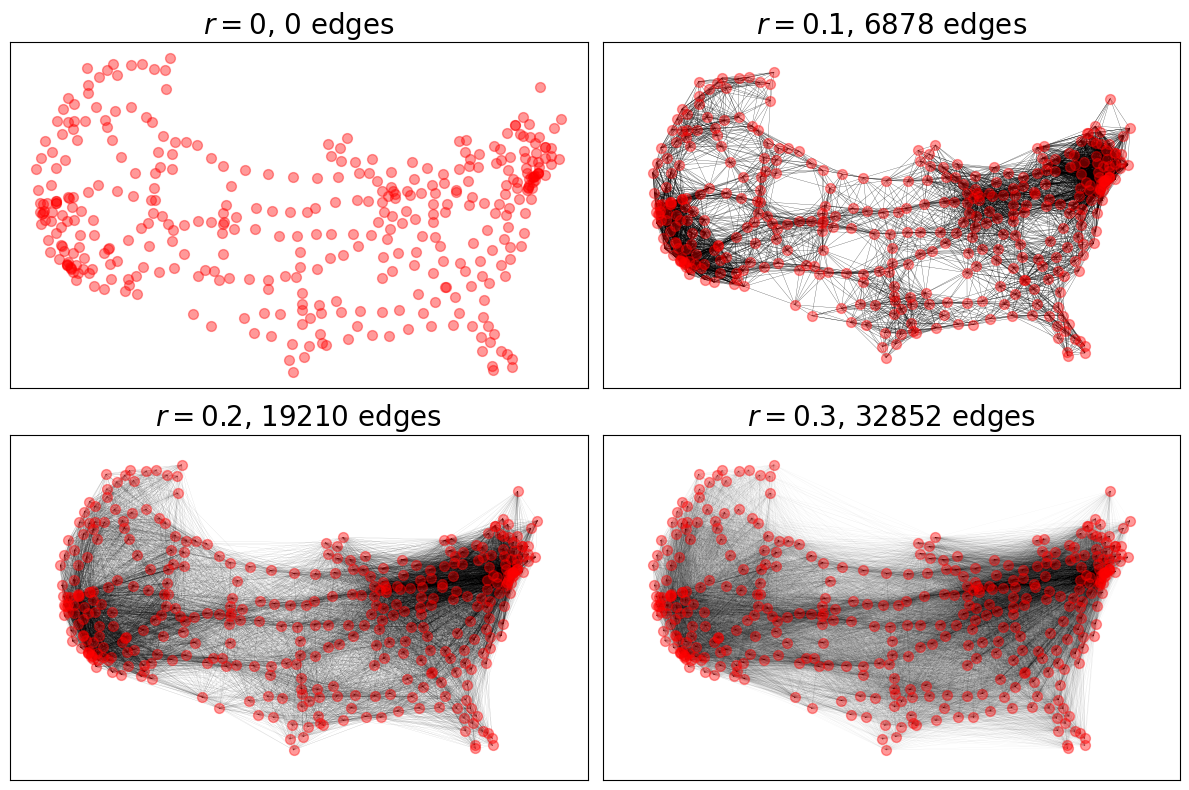

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# 用于可视化边的参数
alphas = (0.8, 0.8, 0.3, 0.1)
linewidths = (0.2, 0.2, 0.1, 0.1)

radii = (0, 0.1, 0.2, 0.3)
for r, ax, alpha, lw in zip(radii, axes.ravel(), alphas, linewidths):
    RGG = nx.random_geometric_graph(nodes, radius=r, pos=pos)
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **node_opts)
    nx.draw_networkx_edges(RGG, pos=pos, ax=ax, alpha=alpha, width=lw, **edge_opts)
    ax.set_title(f"$r = {r}$, {RGG.number_of_edges()} edges")
fig.tight_layout()

In [9]:
# 使边的可视化更加突出（且一致），用于后续示例
edge_opts["alpha"] = 0.8
edge_opts["width"] = 0.2

## 地理阈值图

GTG 模型允许广泛的定制参数，包括自定义节点位置、权重、节点间的度量和连接概率 $P(d_{ij})$。默认的 $P(d_{ij})$ 模型是两个连接节点之间的度量值 $r$。
节点提升到 $-\alpha$ 参数，其默认值为 2。

/tmp/ipykernel_9097/2182451635.py:18: UserWarning: Glyph 40664 (\N{CJK UNIFIED IDEOGRAPH-9ED8}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/2182451635.py:18: UserWarning: Glyph 35748 (\N{CJK UNIFIED IDEOGRAPH-8BA4}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/2182451635.py:18: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/2182451635.py:18: UserWarning: Glyph 27431 (\N{CJK UNIFIED IDEOGRAPH-6B27}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/2182451635.py:18: UserWarning: Glyph 20960 (\N{CJK UNIFIED IDEOGRAPH-51E0}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/2182451635.py:18: UserWarning: Glyph 37324 (\N{CJK UNIFIED IDEOGRAPH-91CC}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/2182451635.py:18: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}

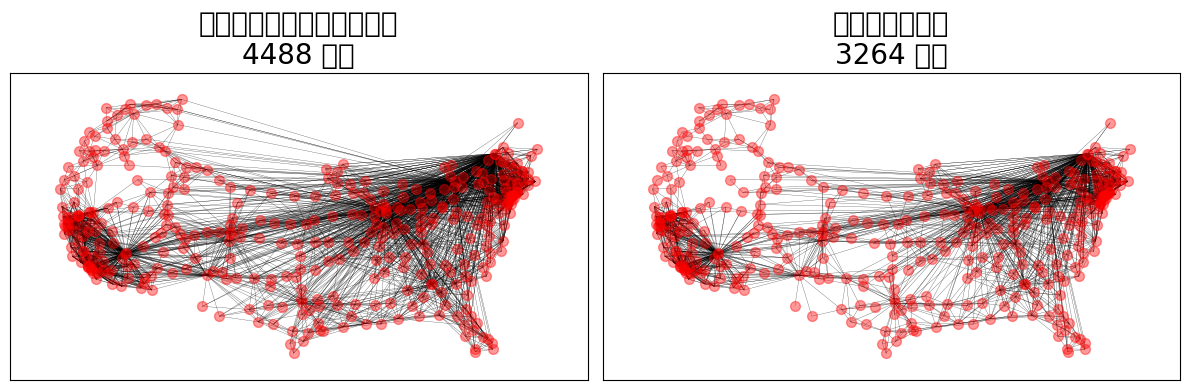

In [10]:
fig, axes = plt.subplots(1, 2)

# 自定义距离度量
dist = lambda x, y: sum(abs(a - b) for a, b in zip(x, y))

distance_metrics = {
    "默认（欧几里得）距离度量": None,  # 欧几里得距离
    "自定义距离度量": dist,
}

for (name, metric), ax in zip(distance_metrics.items(), axes.ravel()):
    GTG = nx.geographical_threshold_graph(
        nodes, 0.1, pos=pos, weight=weight, metric=metric
    )
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **node_opts)
    nx.draw_networkx_edges(GTG, pos=pos, ax=ax, **edge_opts)
    ax.set_title(f"{name}\n{GTG.number_of_edges()} 条边")
fig.tight_layout()

/tmp/ipykernel_9097/656395056.py:19: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/656395056.py:19: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/656395056.py:19: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/656395056.py:19: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/656395056.py:19: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/656395056.py:19: UserWarning: Glyph 36793 (\N{CJK UNIFIED IDEOGRAPH-8FB9}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/656395056.py:19: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missi

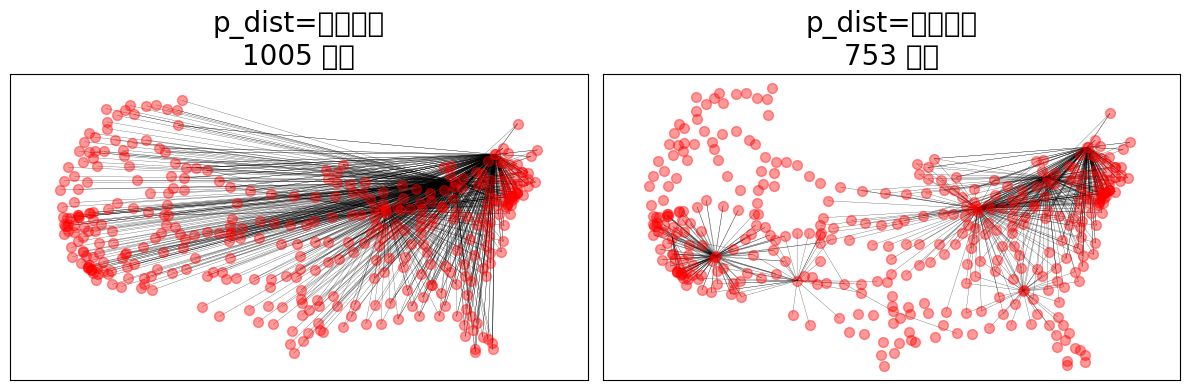

In [11]:
fig, axes = plt.subplots(1, 2)

# 评估不同的 p_dist
import math
from scipy.stats import norm

p_dists = {
    "p_dist=指数分布": lambda d: math.exp(-d),
    "p_dist=正态分布": norm(loc=0.1, scale=0.1).pdf,
}

for (name, p_dist), ax in zip(p_dists.items(), axes.ravel()):
    GTG = nx.geographical_threshold_graph(
        nodes, 0.01, pos=pos, weight=weight, metric=dist, p_dist=p_dist
    )
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **node_opts)
    nx.draw_networkx_edges(GTG, pos=pos, ax=ax, **edge_opts)
    ax.set_title(f"{name}\n{GTG.number_of_edges()} 条边")
fig.tight_layout()

## 软随机几何图

SRGGs 利用 RGGs 的最大连接距离参数 $R$，但提供了输入任意连接概率函数 $P(d_{ij})$ 的能力，适用于最大连接距离内的节点。networkx 中 SRGGs 的默认 $P(d_{ij})$ 函数是速率参数为 `lambda=1` 的指数分布。

/tmp/ipykernel_9097/946411515.py:13: UserWarning: Glyph 40664 (\N{CJK UNIFIED IDEOGRAPH-9ED8}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/946411515.py:13: UserWarning: Glyph 35748 (\N{CJK UNIFIED IDEOGRAPH-8BA4}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/946411515.py:13: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/946411515.py:13: UserWarning: Glyph 36793 (\N{CJK UNIFIED IDEOGRAPH-8FB9}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/946411515.py:13: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/946411515.py:13: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/946411515.py:13: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missi

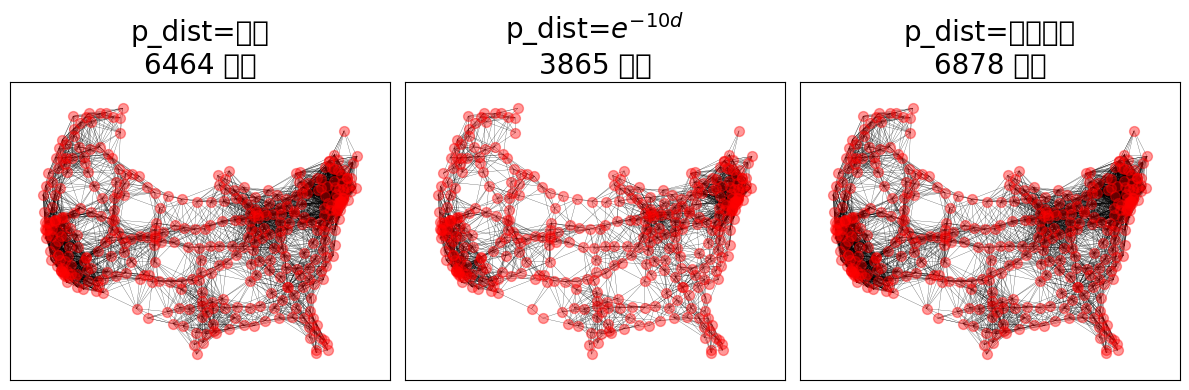

In [12]:
fig, axes = plt.subplots(1, 3)

pdfs = {
    "默认": None,  # 默认：速率参数为 `lambda=1` 的指数分布
    r"$e^{-10d}$": lambda d: math.exp(-10 * d),
    "正态分布": norm(loc=0.1, scale=0.1).pdf,
}
for (title, pdf), ax in zip(pdfs.items(), axes.ravel()):
    SRGG = nx.soft_random_geometric_graph(nodes, 0.1, pos=pos, p_dist=pdf)
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **node_opts)
    nx.draw_networkx_edges(SRGG, pos=pos, ax=ax, **edge_opts)
    ax.set_title(f"p_dist={title}\n{SRGG.number_of_edges()} 条边")
fig.tight_layout()

## 阈值随机几何图

TRGGs 允许最大连接距离和阈值参数的耦合。TRGG 的默认权重从速率参数为 `lambda=1` 的指数分布中抽取。

/tmp/ipykernel_9097/982547651.py:12: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/982547651.py:12: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/982547651.py:12: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/tmp/ipykernel_9097/982547651.py:12: UserWarning: Glyph 36793 (\N{CJK UNIFIED IDEOGRAPH-8FB9}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 38408 (\N{CJK UNIFIED IDEOGRAPH-9608}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-pac

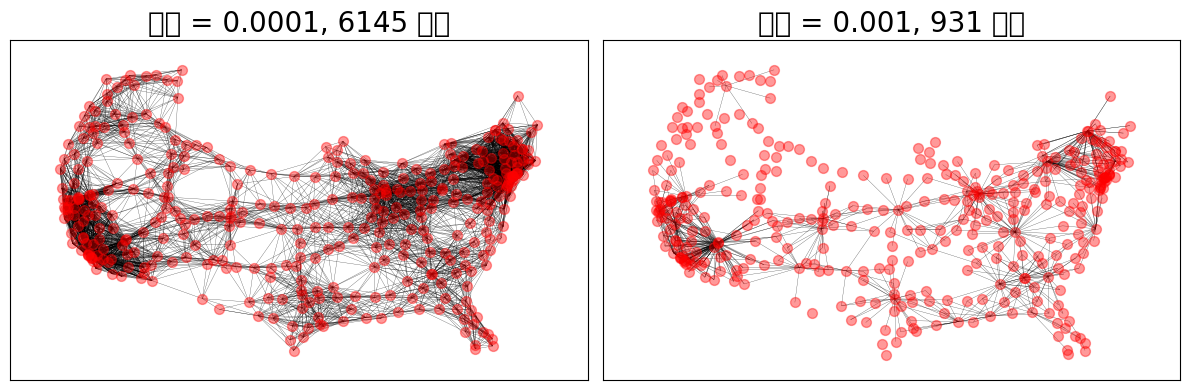

In [13]:
fig, axes = plt.subplots(1, 2)

# 增加阈值参数 theta 会降低图的连通性
thresholds = (0.0001, 0.001)
for thresh, ax in zip(thresholds, axes):
    TRGG = nx.thresholded_random_geometric_graph(
        nodes, 0.1, thresh, pos=pos, weight=weight
    )
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **node_opts)
    nx.draw_networkx_edges(TRGG, pos=pos, ax=ax, **edge_opts)
    ax.set_title(f"阈值 = {thresh}, {TRGG.number_of_edges()} 条边")
fig.tight_layout()

## 参考文献

[^1]: 空间网络 <https://doi.org/10.1016/j.physrep.2010.11.002>

[^2]: 随机几何图 <https://doi.org/10.1103/PhysRevE.66.016121>

[^3]: 单位圆盘图 <https://doi.org/10.1016/0012-365X(90)90358-O>

[^4]: Waxman 图 <https://doi.org/10.1109/49.12889>

[^6]: 阈值图 - <https://doi.org/10.37236/219>

[^7]: 软几何随机图 - <https://doi.org/10.1214/15-AAP1110>

[^8]: 几何阈值图 - <https://doi.org/10.1103/PhysRevE.71.036108>

[^9]: 阈值随机几何图 - <http://hdl.handle.net/2117/111425>